**Please remember that the first step is to make a copy of this notebook, and then share that notebook with me. Detailed steps on how to share the notebook are available in the presentation from December 9.**

# Rules

The data in this project are provided by Citi for our use in this project. You are not permitted to share it beyond this course.

You are not allowed to discuss the project with anyone other than the instructor.

You are allowed to access any resources (other than communicating with other people), including the course notes, recordings, and other online materials. Cite resources used as appropriate.

If something is not specified in the instructions, then you are to take the steps that you believe are the most appropriate. For example, if I don't tell you which clustering algorithm to use, you are to choose which one to use.

At all times you will be assessed, in part, in the clarity of your presentation including your writing and any visualization that you provide.

Everything you do must be contained within this notebook. You will not be submitting a pdf version. I will grade the notebook directly.

The number of points for each portion is shown in bold, e.g., **(10)**.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

The following will read in the data for the project.

In [ ]:
fulldata = pd.read_csv("http://www.stat.cmu.edu/~cschafer/MSCF/FinalProjectData.csv")
fulldata.head()

,spoof,price_level,side,size,L1BidVolume,L1AskVolume,L2BidVolume,L2AskVolume,L3BidVolume,L3AskVolume,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9
0,1,1,1,0,0,0,0,2,1,1,0.285473,0.307095,-0.162560,0.571682,-0.927855,0.266910,0.419302,0.375334,0.197479,0.440146
1,1,1,1,0,3,0,3,0,1,3,0.171987,0.148828,-0.126636,0.707624,-1.028241,0.327790,0.392594,0.498095,0.144682,0.580797
2,0,4,1,0,1,2,1,1,2,0,1.136343,1.354168,0.555337,-0.691090,0.982827,-0.859628,-0.333628,-0.713966,0.909916,-0.609235
3,0,1,0,0,0,0,0,0,1,1,0.165092,0.168728,-0.023689,0.548146,-0.729518,-0.071050,0.268721,0.567562,0.063072,0.553360
4,0,4,1,0,1,0,1,2,1,1,1.135701,1.284084,0.312814,-0.561310,0.310497,-0.092963,-0.029125,-0.562302,0.804659,-0.537767


# Variable Explanations

In what follows, I will be making reference to three types of variables. 

First, there is the **response**:

1.   `spoof`: a value of 1 indicates a case of spoofing

Second, there are the **original features**:

2.   `price_level`: Price level in the book of this transaction. See the overview presentation for an illustration.
3. `side`: 0 indicates a buy, 1 indicates a sell
4. `size`: The size of the order.
5. `LxBidVolume`: Volume in book at level x on the bid side. See the overview presentation for an illustration.
6. `LxAskVolume`: Volume in book at level x on the ask side. See the overview presentation for an illustration.

Third, there are the **derived features**:
7. `X0` thru `X9`: The features derived from the neural network.

Note that the size and volume variables have been binned, and take values from 0 to 4. 0 indicates smaller number of shares, while 4 is highest number of shares. These measures are taken relative to typical trade volumes for the stock.




# Big Picture

To start, make sure you have watched the introductory presentation that I made in lecture on December 9. It provides important background on the problem.

This project is about exploring the relationships between the derived features and the original features, and explaining to someone how the original features are being used to make the classifications. In other words, we are trying to cut through, to the extent possible, the "black box" nature of neural networks.

Please remember that I am **not** asking you to give a tutorial on neural networks. The point is **not** to describe how neural networks produce classifications from inputs. This exercise requires zero knowledge of how neural networks function. For each step you take, ask yourself: "Does doing this require knowledge of how a neural network functions?" If the answer is "Yes" then you are going in a wrong direction.


# Part 1: Exploratory Questions

## Task 1

Run the code below. Comment on the output in the text box below. **(5)**

1. All derived features have a clear bimodal distribution except maybe X5 which is not as clear
1. All derived features are highly correlated to each other except X4 and X5
1. There is a clear nonlinear relationship between some of the derived features (e.g., X0 and X2)


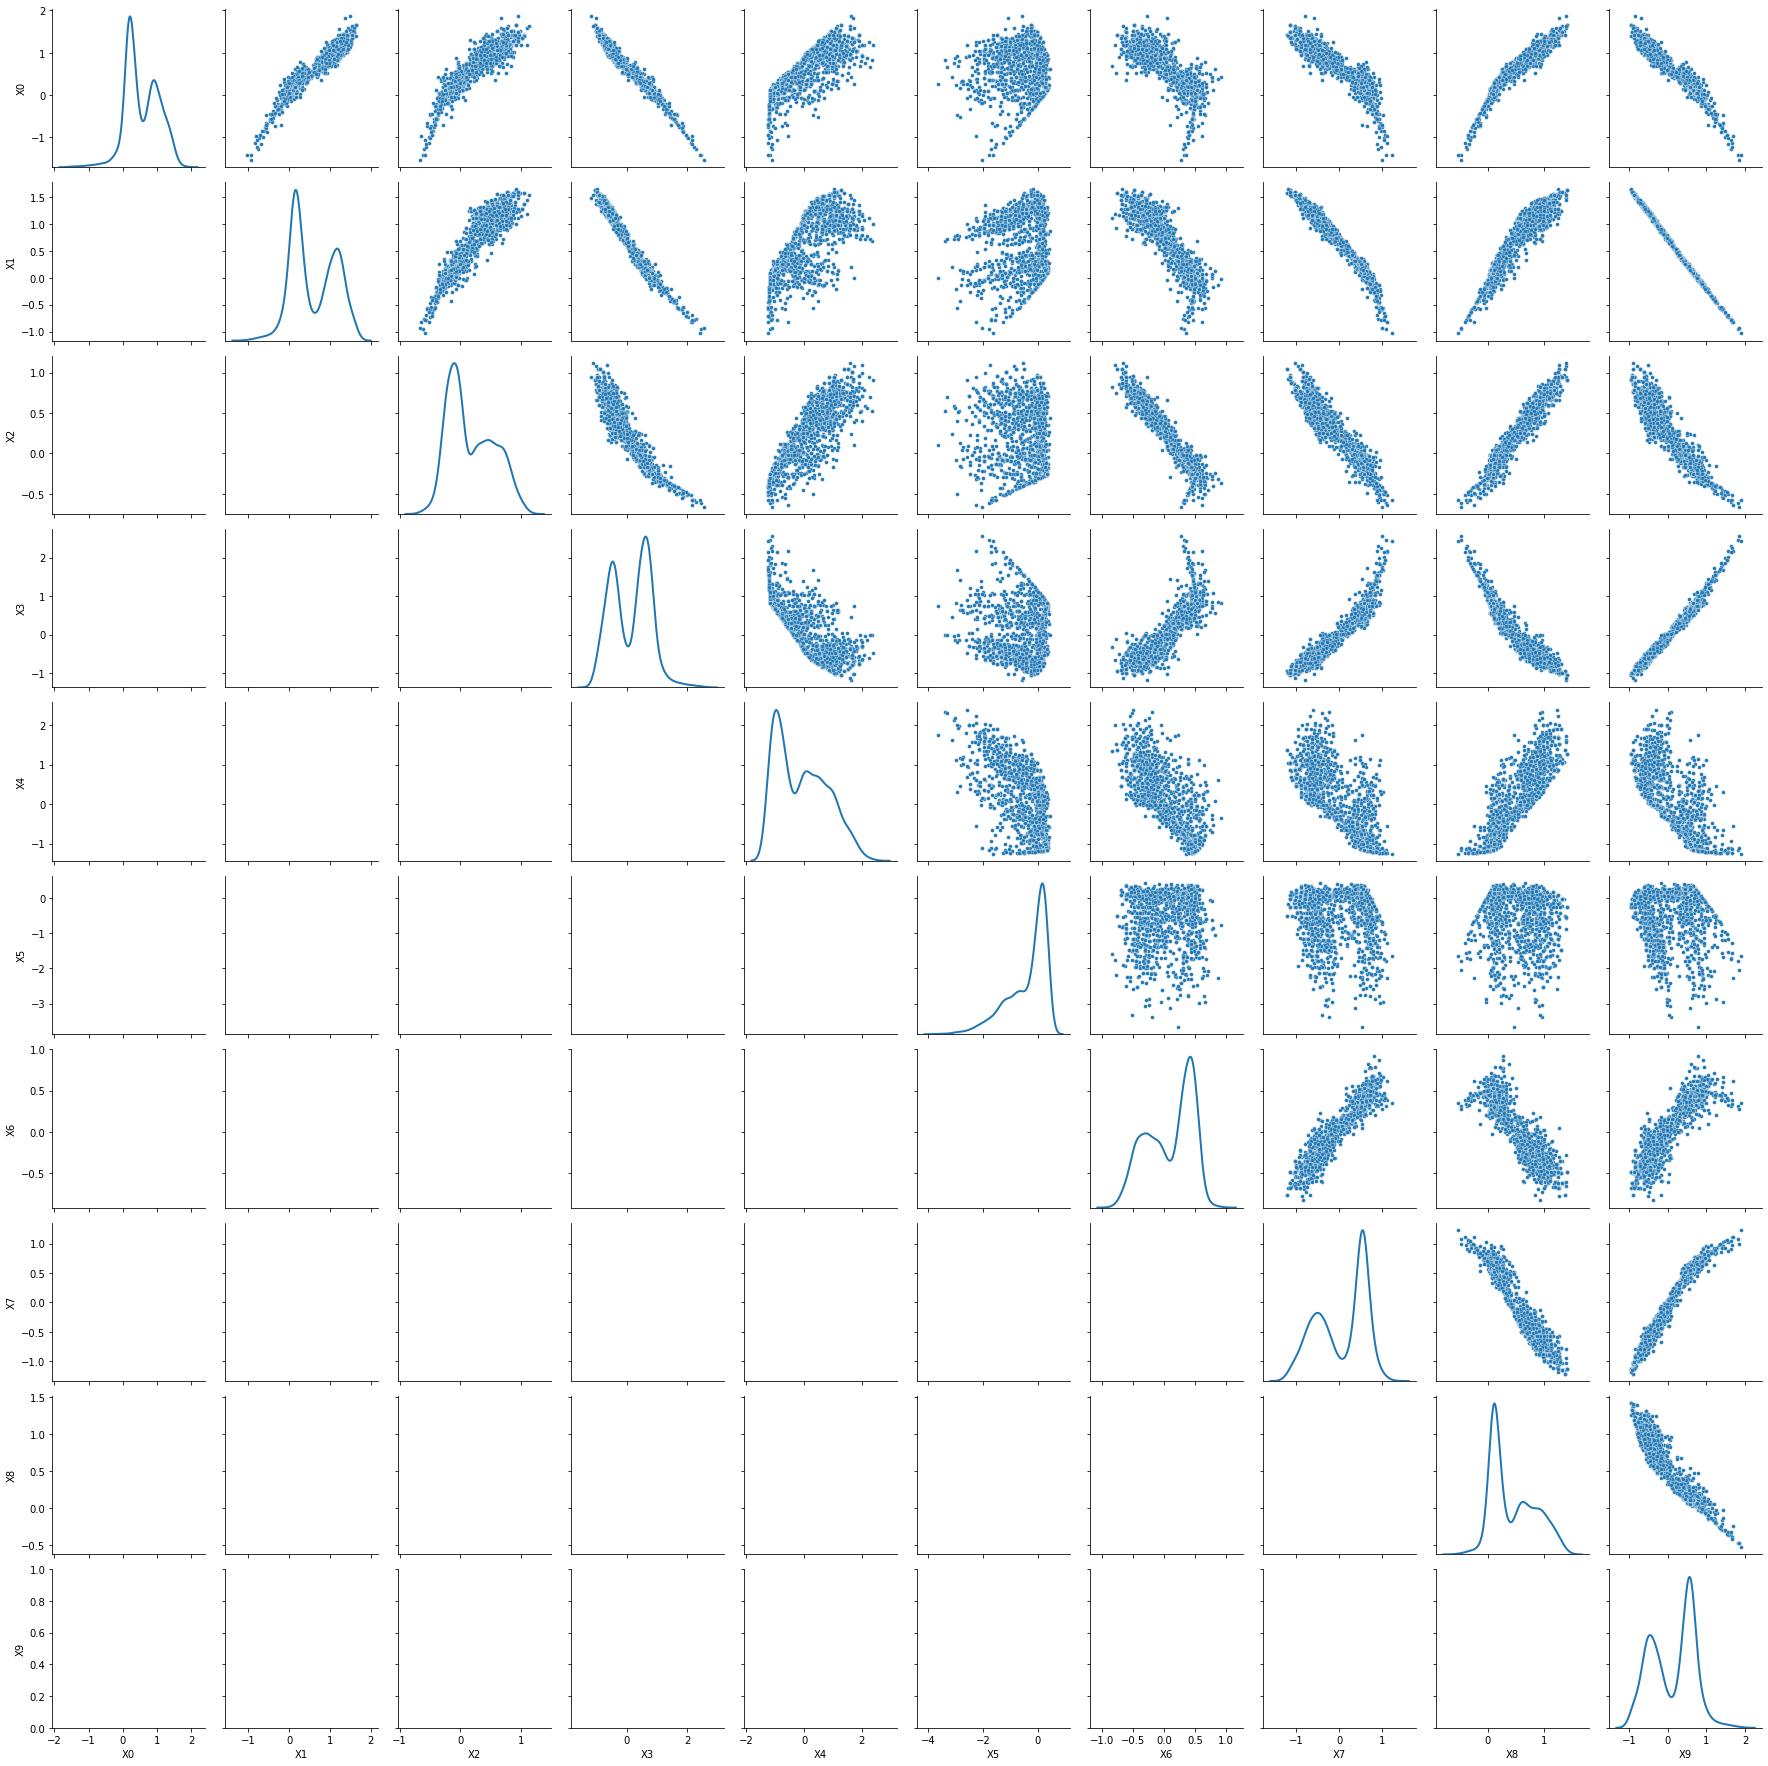

In [ ]:
derivedfeatures = fulldata.iloc[:,10:20]

g = sns.PairGrid(derivedfeatures, diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_diag(sns.kdeplot, lw=2)

## Task 2

Run PCA on the **derived features**. Add columns to the data frame based on this analysis. Do not add more dimensions than you believe are necessary, and justify your choices. **(10)**

Below are the scree plot and a plot of the first 3 principal components. The PCA is performed on the standardized data. 

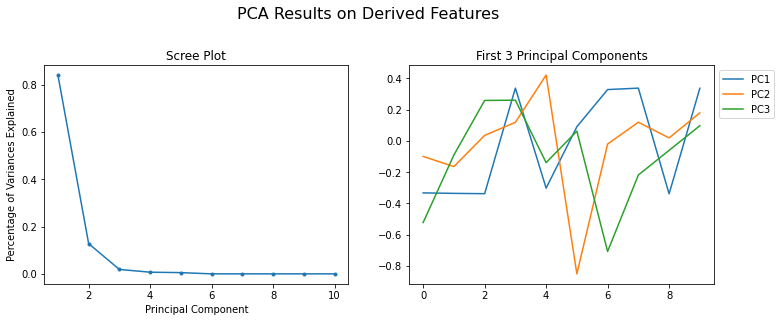

In [ ]:
from pandas import Series, DataFrame
from sklearn.decomposition import PCA

fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))

derivedfeatures = (derivedfeatures - derivedfeatures.mean())/derivedfeatures.std()

n_components = 10
pcaout = PCA(n_components=n_components).fit(derivedfeatures)
Series(pcaout.explained_variance_ratio_, index=range(1, n_components+1)).plot(style='.-', ax=ax[0])
DataFrame(pcaout.components_[:3].T, columns=['PC1', 'PC2', 'PC3']).plot(ax=ax[1], legend=None)

ax[0].set(title='Scree Plot', ylabel='Percentage of Variances Explained', xlabel='Principal Component')
ax[1].set(title='First 3 Principal Components')

plt.suptitle('PCA Results on Derived Features', fontsize=16)
plt.subplots_adjust(top=0.8)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

The cumulative percentage of variance explained is printed out, which shows that the first 2 components together explain almost 97% of the variances in the 
data. The additional variance explained beyond PC2 is small, so we will only add to the data the PC scores corresponding to the first 2 PCs. 

In [ ]:
pcaout.explained_variance_ratio_.cumsum()

array([0.84124414, 0.96913339, 0.98773746, 0.99479262, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [ ]:
score1, score2 = pcaout.transform(derivedfeatures)[:, :2].T

fulldata['Score1'] = score1
fulldata['Score2'] = score2
fulldata.head()

,spoof,price_level,side,size,L1BidVolume,L1AskVolume,L2BidVolume,L2AskVolume,L3BidVolume,L3AskVolume,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,Score1,Score2
0,1,1,1,0,0,0,0,2,1,1,0.285473,0.307095,-0.162560,0.571682,-0.927855,0.266910,0.419302,0.375334,0.197479,0.440146,2.138840,-0.838629
1,1,1,1,0,3,0,3,0,1,3,0.171987,0.148828,-0.126636,0.707624,-1.028241,0.327790,0.392594,0.498095,0.144682,0.580797,2.572476,-0.788925
2,0,4,1,0,1,2,1,1,2,0,1.136343,1.354168,0.555337,-0.691090,0.982827,-0.859628,-0.333628,-0.713966,0.909916,-0.609235,-3.736184,0.247634
3,0,1,0,0,0,0,0,0,1,1,0.165092,0.168728,-0.023689,0.548146,-0.729518,-0.071050,0.268721,0.567562,0.063072,0.553360,2.220471,-0.197965
4,0,4,1,0,1,0,1,2,1,1,1.135701,1.284084,0.312814,-0.561310,0.310497,-0.092963,-0.029125,-0.562302,0.804659,-0.537767,-2.587700,-0.910673


Below is a scatter plot of the scores, the color indicating whether a data point is spoofing. 

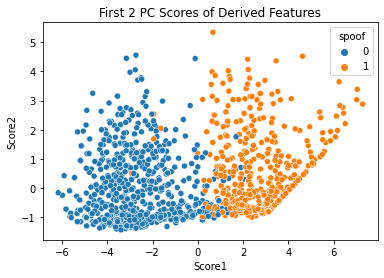

In [ ]:
ax = sns.scatterplot(x='Score1', y='Score2', data=fulldata, hue='spoof')
ax.set(title='First 2 PC Scores of Derived Features')
plt.show()

## Task 3

Run a nonlinear dimension reduction approach on the derived features. Add columns to the data frame based on this analysis. Visualize the results, and comment on structure that you may see. **(10)**

Based on the PCA results, we project the derived features to a 2D plane. We have tried both Isomap and the diffusion map algorithm. As a result, the diffusion map does not reveal any useful information, while the projection by Isomap is very similar to that of PCA. 

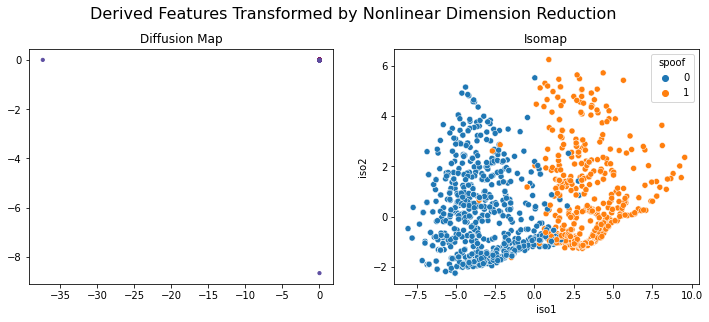

In [ ]:
from pydiffmap import diffusion_map as dm
from sklearn import manifold

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

dmap = dm.DiffusionMap.from_sklearn(n_evecs=10, epsilon="bgh").fit_transform(derivedfeatures)
iso = manifold.Isomap(n_neighbors=10, n_components=2).fit_transform(derivedfeatures)

ax1.scatter(dmap[:, 0], dmap[:, 1], c=fulldata['spoof'], cmap=plt.cm.Spectral, s=10)
ax1.set(title='Diffusion Map')

ax2 = sns.scatterplot(x='iso1', y='iso2', hue='spoof', data=DataFrame({'spoof': fulldata['spoof'], 'iso1': iso[:, 0], 'iso2': iso[:, 1]}))
ax2.set(title='Isomap')

plt.suptitle('Derived Features Transformed by Nonlinear Dimension Reduction', fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

Now we add the Isomap transformed data to the data frame. 

In [ ]:
fulldata['iso1'] = iso[:, 0]
fulldata['iso2'] = iso[:, 1]
fulldata.head()

,spoof,price_level,side,size,L1BidVolume,L1AskVolume,L2BidVolume,L2AskVolume,L3BidVolume,L3AskVolume,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,Score1,Score2,iso1,iso2
0,1,1,1,0,0,0,0,2,1,1,0.285473,0.307095,-0.162560,0.571682,-0.927855,0.266910,0.419302,0.375334,0.197479,0.440146,2.138840,-0.838629,2.652201,-1.067184
1,1,1,1,0,3,0,3,0,1,3,0.171987,0.148828,-0.126636,0.707624,-1.028241,0.327790,0.392594,0.498095,0.144682,0.580797,2.572476,-0.788925,3.050153,-1.172104
2,0,4,1,0,1,2,1,1,2,0,1.136343,1.354168,0.555337,-0.691090,0.982827,-0.859628,-0.333628,-0.713966,0.909916,-0.609235,-3.736184,0.247634,-4.783878,0.452232
3,0,1,0,0,0,0,0,0,1,1,0.165092,0.168728,-0.023689,0.548146,-0.729518,-0.071050,0.268721,0.567562,0.063072,0.553360,2.220471,-0.197965,3.628432,0.195379
4,0,4,1,0,1,0,1,2,1,1,1.135701,1.284084,0.312814,-0.561310,0.310497,-0.092963,-0.029125,-0.562302,0.804659,-0.537767,-2.587700,-0.910673,-3.169145,-1.519548


## Task 4

Cluster the obsevations based on the derived features (or one of the lower-dimensional representations derived above). Add the cluster labels to the data frame. **(10)**

We apply $k$-means clustering and add the resulting label to a new column ```cluster```.

In [ ]:
from sklearn.cluster import KMeans

X = fulldata[['Score1', 'Score2']]
kmout = KMeans(n_clusters=2, n_init=10).fit(X)
fulldata['cluster'] = 1 - kmout.predict(X)

fulldata.head()

,spoof,price_level,side,size,L1BidVolume,L1AskVolume,L2BidVolume,L2AskVolume,L3BidVolume,L3AskVolume,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,Score1,Score2,iso1,iso2,cluster
0,1,1,1,0,0,0,0,2,1,1,0.285473,0.307095,-0.162560,0.571682,-0.927855,0.266910,0.419302,0.375334,0.197479,0.440146,2.138840,-0.838629,2.652201,-1.067184,1
1,1,1,1,0,3,0,3,0,1,3,0.171987,0.148828,-0.126636,0.707624,-1.028241,0.327790,0.392594,0.498095,0.144682,0.580797,2.572476,-0.788925,3.050153,-1.172104,1
2,0,4,1,0,1,2,1,1,2,0,1.136343,1.354168,0.555337,-0.691090,0.982827,-0.859628,-0.333628,-0.713966,0.909916,-0.609235,-3.736184,0.247634,-4.783878,0.452232,0
3,0,1,0,0,0,0,0,0,1,1,0.165092,0.168728,-0.023689,0.548146,-0.729518,-0.071050,0.268721,0.567562,0.063072,0.553360,2.220471,-0.197965,3.628432,0.195379,1
4,0,4,1,0,1,0,1,2,1,1,1.135701,1.284084,0.312814,-0.561310,0.310497,-0.092963,-0.029125,-0.562302,0.804659,-0.537767,-2.587700,-0.910673,-3.169145,-1.519548,0


## Task 5

How are the cluster labels you found in Task 4 related to the response? **(5)**

Here is a scatter plot of the PC scores colored by clusters. This is very similar to our previous plot colored by spoofing, which indicates that the cluster label is a good prediction for spoofing. 

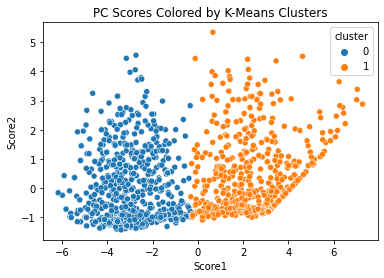

In [ ]:
ax = sns.scatterplot(x='Score1', y='Score2', data=fulldata, hue='cluster')
ax.set(title='PC Scores Colored by K-Means Clusters')
plt.show()

Below is a summary of the cluster label as a predition. The precision is 91.5% and the recall is 98.5%. 

In [ ]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(fulldata['spoof'], fulldata['cluster'])
DataFrame(confusion, columns=['Guess 0', 'Guess 1'], index=['True 0', 'True 1'])

,Guess 0,Guess 1
True 0,873,95
True 1,15,1027


In [ ]:
tn, fp, fn, tp = confusion.ravel()
tp/(tp + fp), tp/(tp + fn)

(0.9153297682709447, 0.9856046065259118)

## Task 6

How are the cluster labels you found in Task 4 to the observed features? **(10)**

## Task 7

The current status of the order book is captured by the six observed variables `L1AskVolume`, `L1BidVolume`, and so forth.

It makes sense to ask if a low-dimensional representation of this information would preserve important information.

Take an appropriate approach to create a one-dimensional representation of the current status of the order book. **(10)**

## Task 8

Explore the relationship, if any, between the one-dimensional representation of the order book you found in Task 7 and the derived features (or the representations you found of the derived features). Use appropriate smoothing methods in your visualizations. (For example, if your one-dimensional representation of the order book is continuous, you could plot that versus `X0`, but put a nonparametric smooth on that plot.) **(5)**

# Part 2: Getting at the Relationships

Now for the big question: What can you say about the relationship between the derived features and the observed features?

I will start you with a suggestion: Inspect the relationship between the first principal component from Task 2 and the variable `size`. The variable `size` has a clear relationship with the response (verify this). Hence, a clear statement can be made about how the first principal component is taking advantage of size to achieve better classifications.

You should start with the above example, but you should then demonstrate **two additional relationships** that you find among the variables. Again, remember that the goal is to be able to describe how the derived variables are using the observed variables to reach the classifications.

This part is worth a total of 30 points. You will be assessed on 

1.   The **appropriateness of the methods** used to find and present the relationship. This includes appropriate choice of visualizations. **(20)**
2. The **clarity of the written explanations** of the results. Be clear, not necessarily wordy. **(10)**
3. The **clarity of the visualizations**. Label your axes appropriately, etc. **(5)**

In addition, I reserve the right to penalize you for not exploring a variety of relationships. (For example, the derived features are strongly correlated. Don't repeat the same thing three times using three different derived features.)
